In [1]:
%matplotlib notebook

In [2]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from torchdiffeq import odeint_adjoint as odeint

In [4]:
parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true');

In [5]:
arguments = [
    "--method", "dopri5",
    "--niters", "10000",
    "--batch_size", "100",
    "--test_freq", "1000",
    "--viz"
]
args = parser.parse_args(arguments)

In [6]:
import matplotlib.pyplot as plt
class KVPlotter() :
    def __init__(self, nrows, ncols, **kwargs) :
        self.fig = plt.figure(figsize=(12, 4), facecolor='white')
        self.axis = [self.fig.add_subplot(nrows,ncols,i+1,frameon=False) for i in range(nrows*ncols)]
    def plot(self, keys, values, xlabel='x', ylabel='y', index=0) :
        axis = self.axis[index]
        axis.cla()
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.plot(keys, values)
        self.fig.tight_layout()
        plt.show()
class TrajectoryPlotter() :
    def __init__(self, *args, **kwargs) :
        self.fig = plt.figure(figsize=(12, 4), facecolor='white')
        self.ax_traj = self.fig.add_subplot(131, frameon=False)
        self.ax_phase = self.fig.add_subplot(132, frameon=False)
        self.ax_vecfield = self.fig.add_subplot(133, frameon=False)
    def visualize(self, true_y, pred_y, odefunc, itr) :
        ax_traj, ax_phase, ax_vecfield = self.ax_traj, self.ax_phase, self.ax_vecfield
        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)
        # ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        self.fig.tight_layout()
        # fig.show()
        # plt.savefig('png/{:03d}'.format(itr))
        # plt.draw()
        plt.show()
        # plt.pause(0.001)

In [7]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

ODE function to be approximated
$$
\dot{\boldsymbol{y}} = \boldsymbol{y}_{0} + f(y) \\
f(y) = A\boldsymbol{y}^{3} \\
A = 
\begin{bmatrix}
-0.1 & 2.0 \\
2.0 & -0.1 
\end{bmatrix}, \quad
\boldsymbol{y}_{0} = 
\begin{bmatrix}
2.0 & 0.0
\end{bmatrix}^{T}
$$

In [8]:
# initial value
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., args.data_size)
# true dynamics
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

# nonlinear dynamics
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)
    
# compute true output
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [9]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:args.batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

<IPython.core.display.Javascript object>


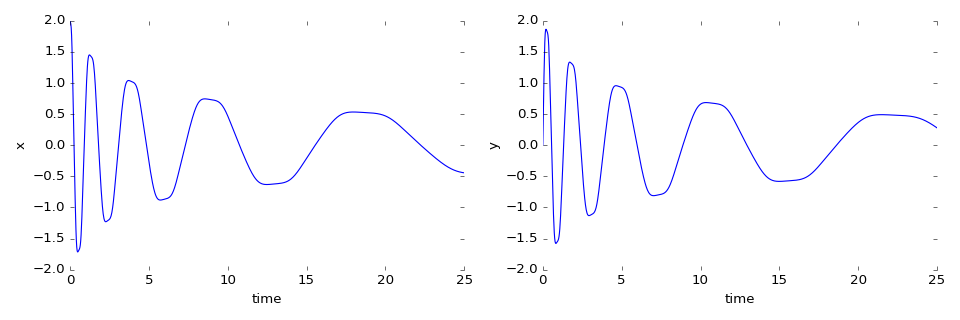

In [10]:
# print('{}\n{}'.format(true_y,true_y**3))
plotter = KVPlotter(nrows=1,ncols=2)
plotter.plot(t.numpy(),true_y.numpy()[:, 0, 0], xlabel='time', ylabel='x', index=0)
plotter.plot(t.numpy(),true_y.numpy()[:, 0, 1], xlabel='time', ylabel='y', index=1)
b_y0, b_t, b_y = get_batch()
# plotter = KVPlotter(nrows=1,ncols=2)
# plotter.plot(b_t.numpy(),b_y0.numpy()[:len(b_t), 0, 0], xlabel='time', ylabel='x', index=0)
# plotter.plot(b_t.numpy(),b_y0.numpy()[:len(b_t), 0, 1], xlabel='time', ylabel='y', index=1)

Define ODE function dynamics approximator (as nn.Module extension), consisted of 3 layers :   
* Linear layer with input size 2 and output size 50   
* Tanh layer 
* Linear layer with input size 50 and output size 2  

In [11]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    def forward(self, t, y):
        return self.net(y**3)

Helper class to store values

In [12]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()
        self.values = []
    def reset(self):
        self.val = None
        self.avg = 0
    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.values.append(val)
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

Create instance of ODE function and optimizer

In [13]:
ii = 0
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

<IPython.core.display.Javascript object>


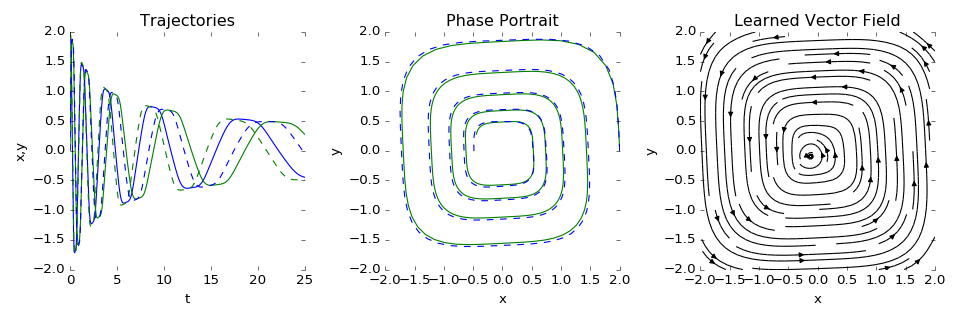

Iter 1000 | Total Loss 0.734200
Iter 2000 | Total Loss 0.410508
Iter 3000 | Total Loss 0.215225
Iter 4000 | Total Loss 0.761739
Iter 5000 | Total Loss 0.158503
Iter 6000 | Total Loss 0.718595
Iter 7000 | Total Loss 0.613113
Iter 8000 | Total Loss 0.290023
Iter 9000 | Total Loss 0.737215
Iter 10000 | Total Loss 0.185892


In [14]:
plotter = TrajectoryPlotter()
for itr in range(1, args.niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args.test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            plotter.visualize(true_y, pred_y, func, ii)
            ii += 1
    end = time.time()

Show loss and timing data

<IPython.core.display.Javascript object>


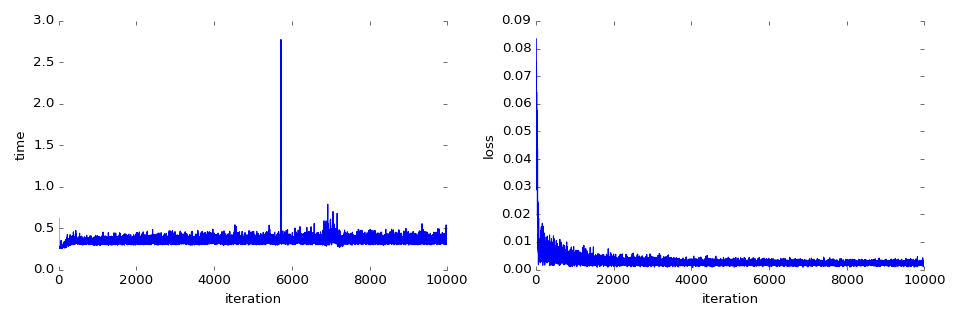

In [15]:
plotter = KVPlotter(nrows=1,ncols=2)
plotter.plot(range(len(time_meter.values)),time_meter.values,xlabel='iteration',ylabel='time',index=0)
plotter.plot(range(len(loss_meter.values)),loss_meter.values,xlabel='iteration',ylabel='loss',index=1)